# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, make_scorer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from nltk.corpus import stopwords
import time
import pickle

#nltk.download()
nltk.download('wordnet')
nltk.download('stopwords')


'''
pip install XGBoost
'''
from xgboost import XGBClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xumingsheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xumingsheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


D:\Anaconda3\lib\site-packages\xgboost\__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
# load data from database
engine = create_engine('sqlite:///cleanTable.db')
df = pd.read_sql_table("cleanTable", con=engine)
X = df[["message", "genre"]]
Y = df.drop(axis=1, labels=["id", "message", "original", "genre"])

print(df.columns)

Index(['id', 'message', 'original', 'genre', 'related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


In [3]:
df.head()
for i in range(len(df.columns)):
    if len(df[df.columns[i]].unique()) == 1:
        print( df.columns[i])

child_alone


In [4]:
Y = Y.drop(axis=1, labels="child_alone")
x_train, x_test, y_train, y_test = train_test_split(X['message'], Y, random_state=42)


### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for token in tokens:
        clean_tok = lemmatizer.lemmatize(token).lower().strip()
        
        # remove stop words 
        if clean_tok not in set(stopwords.words("english")):
            clean_tokens.append(clean_tok) 
    return clean_tokens


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

#### Random Forest model

In [15]:
pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(RandomForestClassifier()))]) 

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [16]:
#train the model
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
def plot_scores(y, y_pred):
    
    f1_series = pd.Series()
    
    for i_col in range(y.shape[1]):
        print(y.columns[i_col])
        print(classification_report(y.iloc[:,i_col], y_pred[:,i_col]))
        f1_series[y.columns[i_col]] = f1_score(y.iloc[:,i_col], y_pred[:,i_col], average='weighted')
    plt.figure(figsize=[12,6])
    f1_series.sort_values(ascending=False).plot(kind="bar" )
    print("f1 score mean : ", f1_series.mean())

In [18]:
y_test_pred = pipeline.predict(x_test)
plot_scores(y_test, y_test_pred)

related
             precision    recall  f1-score   support

          0       0.61      0.44      0.51      1563
          1       0.83      0.91      0.87      4944
          2       0.39      0.28      0.33        47

avg / total       0.78      0.79      0.78      6554

request
             precision    recall  f1-score   support

          0       0.90      0.98      0.94      5443
          1       0.82      0.44      0.57      1111

avg / total       0.88      0.89      0.87      6554

offer
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6521
          1       0.00      0.00      0.00        33

avg / total       0.99      0.99      0.99      6554

aid_related
             precision    recall  f1-score   support

          0       0.75      0.86      0.80      3884
          1       0.74      0.59      0.66      2670

avg / total       0.75      0.75      0.74      6554

medical_help
             precision    recall  f1-sco

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score mean :  0.9308122841240642


#### Nultinomial NB

In [19]:
pipeline2 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(MultinomialNB()))]) 

In [20]:
#train the model
pipeline2.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ssifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=1))])

In [21]:
# scores of train data
y_test_pred = pipeline2.predict(x_test)
plot_scores(y_test, y_test_pred)

related
             precision    recall  f1-score   support

          0       0.75      0.08      0.14      1563
          1       0.77      0.99      0.87      4944
          2       0.00      0.00      0.00        47

avg / total       0.76      0.77      0.69      6554

request
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      5443
          1       0.84      0.22      0.34      1111

avg / total       0.86      0.86      0.82      6554

offer
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      6521
          1       0.00      0.00      0.00        33

avg / total       0.99      0.99      0.99      6554

aid_related
             precision    recall  f1-score   support

          0       0.77      0.83      0.80      3884
          1       0.72      0.64      0.68      2670

avg / total       0.75      0.75      0.75      6554

medical_help
             precision    recall  f1-sco

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score mean :  0.9111193237316576


#### LogisticRegresion model

In [15]:
pipeline3 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(LogisticRegression()))])

In [16]:
pipeline3.fit(x_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(C=1.0,
                                                                    class_weight=None,
                 

related
              precision    recall  f1-score   support

           0       0.73      0.41      0.52      1563
           1       0.83      0.95      0.89      4944
           2       0.00      0.00      0.00        47

    accuracy                           0.82      6554
   macro avg       0.52      0.45      0.47      6554
weighted avg       0.80      0.82      0.79      6554

request
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      5443
           1       0.83      0.52      0.64      1111

    accuracy                           0.90      6554
   macro avg       0.87      0.75      0.79      6554
weighted avg       0.90      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      655

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6231
           1       0.88      0.20      0.32       323

    accuracy                           0.96      6554
   macro avg       0.92      0.60      0.65      6554
weighted avg       0.96      0.96      0.95      6554

electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6407
           1       0.79      0.07      0.14       147

    accuracy                           0.98      6554
   macro avg       0.88      0.54      0.56      6554
weighted avg       0.97      0.98      0.97      6554

tools
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6511
           1       0.00      0.00      0.00        43

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554

h

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  # Remove the CWD from sys.path while we load stuff.


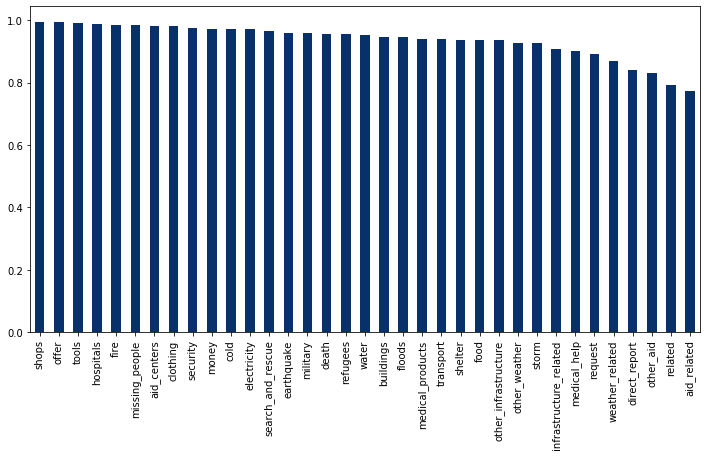

In [17]:
# scores of train data
y_test_pred = pipeline3.predict(x_test)
plot_scores(y_test, y_test_pred)

### 6. Improve your model
Use grid search to find better parameters.  

LogisticRegresion model's mean f1 score is higher.
Now we select Logistic Regresion model to ajust model params.

In [18]:
parameters = {
    "vect__ngram_range" : [(1,1), (1,2)],
    "vect__max_features" : [None, 5000, 10000],
    "clf__estimator__C" : [0.1,1,10]
    }
cv = GridSearchCV(pipeline3, param_grid=parameters, n_jobs=-1, cv=2)


In [19]:
cv.fit(x_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

related
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1563
           1       0.85      0.91      0.88      4944
           2       0.83      0.21      0.34        47

    accuracy                           0.81      6554
   macro avg       0.78      0.55      0.60      6554
weighted avg       0.80      0.81      0.80      6554

request
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5443
           1       0.77      0.57      0.66      1111

    accuracy                           0.90      6554
   macro avg       0.84      0.77      0.80      6554
weighted avg       0.89      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      655

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6231
           1       0.77      0.33      0.46       323

    accuracy                           0.96      6554
   macro avg       0.87      0.66      0.72      6554
weighted avg       0.96      0.96      0.95      6554

electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6407
           1       0.70      0.20      0.32       147

    accuracy                           0.98      6554
   macro avg       0.84      0.60      0.65      6554
weighted avg       0.98      0.98      0.97      6554

tools
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6511
           1       0.00      0.00      0.00        43

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554

h

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  # Remove the CWD from sys.path while we load stuff.


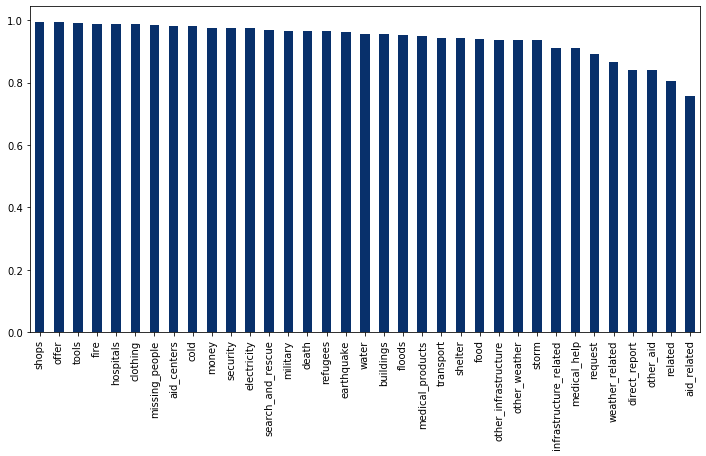

In [20]:
# scores of test data
y_test_pred = cv.predict(x_test)
plot_scores(y_test, y_test_pred)

#### compare model result：
|model|average f1 score|
|:----|:----|
|Random Forest|0.929|
|MultinomialNB|0.911|
|Logistic Regresion|0.936|
|Logistic Regresion + GridSearch|0.9399|

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

xgboost param ref:
https://blog.csdn.net/Liangjun_Feng/article/details/79809037

#### Try XGboost model

In [6]:
pipeline4 = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", MultiOutputClassifier(XGBClassifier()))])

In [7]:
# get prediction
pred = pipeline4.fit(x_train, y_train)

related
              precision    recall  f1-score   support

           0       0.68      0.37      0.48      1563
           1       0.82      0.94      0.88      4944
           2       0.55      0.13      0.21        47

    accuracy                           0.80      6554
   macro avg       0.68      0.48      0.52      6554
weighted avg       0.79      0.80      0.78      6554

request
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5443
           1       0.80      0.54      0.64      1111

    accuracy                           0.90      6554
   macro avg       0.85      0.76      0.79      6554
weighted avg       0.89      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      655

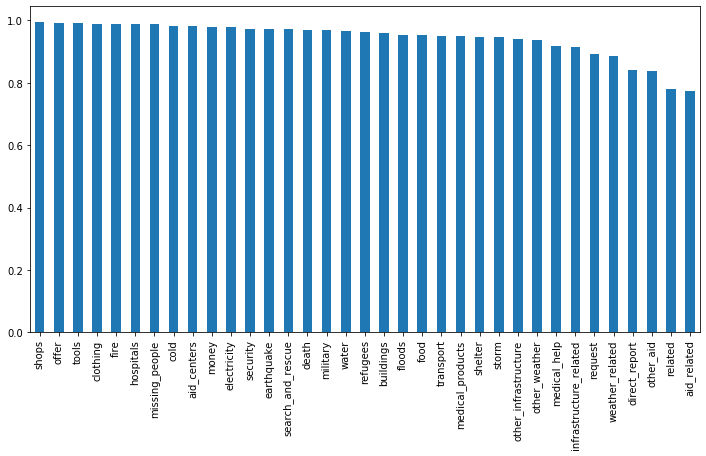

In [10]:
# scores of train data
y_test_pred = pipeline4.predict(x_test)
plot_scores(y_test, y_test_pred)

#### Try XGboost model add other features
reference from here: 
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class BasicTextAnalytics(BaseEstimator, TransformerMixin):
    '''
    Class for returning some basic numerical data for text analysis to include in 
    modelling. Such as: 
    - Number of sentences
    - Number of words
    - Number of nouns
    - Number of verbs
    - Number of adjectives
    A lot of the above were taken from ideas found here: 
    https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/
    '''
    pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }

    # function to check and get the part of speech tag count of a words in a given sentence
    def check_pos_tag(self, text, flag):
        '''
        Returns the count of a given NL pos_tag, based on user selection. E.g. number of nouns.
        INPUTS
        text - the given text to analyse
        flag - pos family to analyse, one of 'noun', 'pron' , 'verb', 'adj' or 'adv'
        '''
        count = 0
        try:
            wiki = textblob.TextBlob(text)
            for tup in wiki.tags:
                ppo = list(tup)[1]
                if ppo in pos_family[flag]:
                    count += 1
        except:
            pass
        return count
    
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        trainDF = pd.DataFrame()
        trainDF['text'] = X
        trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
        trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
        trainDF['noun_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'noun'))
        trainDF['verb_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'verb'))
        trainDF['adj_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'adj'))
        trainDF['adv_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'adv'))
        trainDF['pron_count'] = trainDF['text'].apply(lambda x: self.check_pos_tag(x, 'pron'))
        
        return trainDF.drop('text',axis=1)

    
pipeline_model = Pipeline([
    ('features', FeatureUnion([
        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('numerical_pipeline', Pipeline([
            ('analytics', BasicTextAnalytics()),
            ('norm', StandardScaler())
            ]))
    ])),

    ('clf', MultiOutputClassifier(XGBClassifier()))
])
# specify parameters for grid search

parameters = {

    'clf__estimator__learning_rate' : [0.1],
    'clf__estimator__max_depth' : [2]
}

grid_cv_search = GridSearchCV(pipeline_model, parameters,scoring = 'f1_weighted', n_jobs=-1, cv=2)
sorted(pipeline_model.get_params().keys())

['clf',
 'clf__estimator',
 'clf__estimator__base_score',
 'clf__estimator__booster',
 'clf__estimator__colsample_bylevel',
 'clf__estimator__colsample_bynode',
 'clf__estimator__colsample_bytree',
 'clf__estimator__gamma',
 'clf__estimator__gpu_id',
 'clf__estimator__importance_type',
 'clf__estimator__interaction_constraints',
 'clf__estimator__learning_rate',
 'clf__estimator__max_delta_step',
 'clf__estimator__max_depth',
 'clf__estimator__min_child_weight',
 'clf__estimator__missing',
 'clf__estimator__monotone_constraints',
 'clf__estimator__n_estimators',
 'clf__estimator__n_jobs',
 'clf__estimator__num_parallel_tree',
 'clf__estimator__objective',
 'clf__estimator__random_state',
 'clf__estimator__reg_alpha',
 'clf__estimator__reg_lambda',
 'clf__estimator__scale_pos_weight',
 'clf__estimator__subsample',
 'clf__estimator__tree_method',
 'clf__estimator__validate_parameters',
 'clf__estimator__verbosity',
 'clf__n_jobs',
 'features',
 'features__n_jobs',
 'features__numerical_p

In [ ]:
grid_cv_search.fit(x_train, y_train)

In [ ]:
grid_cv_search.grid_scores_, grid_cv_search.best_params_, grid_cv_search.best_score_

related
              precision    recall  f1-score   support

           0       0.72      0.23      0.35      1563
           1       0.79      0.97      0.87      4944
           2       0.67      0.04      0.08        47

    accuracy                           0.79      6554
   macro avg       0.73      0.41      0.43      6554
weighted avg       0.78      0.79      0.74      6554

request
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5443
           1       0.85      0.48      0.62      1111

    accuracy                           0.90      6554
   macro avg       0.87      0.73      0.78      6554
weighted avg       0.89      0.90      0.89      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6521
           1       0.00      0.00      0.00        33

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      655

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


transport
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6251
           1       0.71      0.19      0.31       303

    accuracy                           0.96      6554
   macro avg       0.84      0.60      0.64      6554
weighted avg       0.95      0.96      0.95      6554

buildings
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6231
           1       0.81      0.31      0.45       323

    accuracy                           0.96      6554
   macro avg       0.89      0.65      0.71      6554
weighted avg       0.96      0.96      0.95      6554

electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6407
           1       0.69      0.21      0.32       147

    accuracy                           0.98      6554
   macro avg       0.84      0.60      0.66      6554
weighted avg       0.98      0.98      0.9

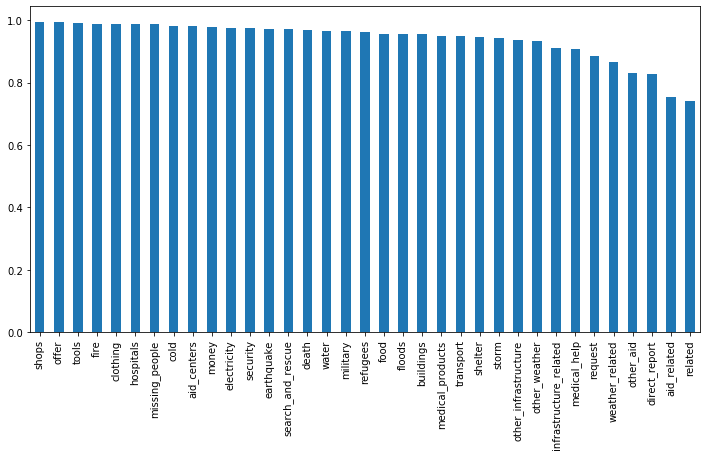

In [11]:
# scores of test data
y_test_pred = grid_cv_search.predict(x_test)
plot_scores(y_test, y_test_pred)

### 9. Export your model as a pickle file

In [25]:
with open("classifier.pkl", 'wb') as file:
    pickle.dump(cv, file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.